# Notebook to analyse the results from hyperparameter search

In [1]:
# Import required libraries and initialize ray

import ray
from ray import tune
from ray.tune import ResultGrid
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from functools import partial
from run.main import train_with_args
from utils.general import load_config
ray.init()

2023-05-28 22:39:43,935	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


## 1. Collect results

In [446]:
# List the available trials in the ray_results directory

ray_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/ray_results/"
experiments = sorted([item.path for item in os.scandir(ray_results_dir) if item.is_dir()])
experiments

['/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_base_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_base_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_context_sessions23_b32',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_loss_sessions13',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_loss_sessions13_v2',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_model_sessions13',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_tokens_session1',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/bart_tokens_sessions23',
 '/Users/FrankVerhoef/Programming/PEX/output/ray_results/trainpex']

In [411]:
# Collect the results from all trials in one Pandas Dataframe

allresults_df = pd.DataFrame()
for exp in experiments:

    # Experiment name is last part of the path
    exp_name = exp.split('/')[-1]

    # Load the appropriate config file to 'reconstruct' the trainable
    baseconfig = load_config(exp + '/base.config')
    restored_tuner = tune.Tuner.restore(exp, trainable=partial(train_with_args, baseconfig))

    # Get the resultgrid for the experiment and append results to dataframe
    result_grid = restored_tuner.get_results()
    df = result_grid.get_dataframe()
    df['experiment_name'] = exp_name
    allresults_df = pd.concat([allresults_df, df], axis=0)

print(f"Collected information about {len(allresults_df)} trials")

2023-05-30 15:52:11,638	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-30 15:52:11,642	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-05-30 15:52:11,791	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` ob

bart_base_sessions23
bart_context_sessions23


2023-05-30 15:52:11,840	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-30 15:52:11,845	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-05-30 15:52:11,980	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` ob

bart_base_session1
bart_context_sessions23_b32
bart_context_session1


2023-05-30 15:52:12,078	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-30 15:52:12,080	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-05-30 15:52:12,123	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` ob

bart_loss_sessions13_v2
bart_tokens_sessions23
bart_loss_sessions13
trainpex
bart_tokens_session1


2023-05-30 15:52:12,322	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-30 15:52:12,327	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


bart_model_sessions13


340

In [447]:
# Show info about available data columns

allresults_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 69
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   valid_loss                  340 non-null    float64
 1   valid_classification_loss   340 non-null    float64
 2   valid_lm_loss               340 non-null    float64
 3   valid_acc                   340 non-null    float64
 4   valid_perplexity            340 non-null    float64
 5   valid_token_prediction_acc  340 non-null    float64
 6   time_this_iter_s            340 non-null    float64
 7   done                        340 non-null    bool   
 8   timesteps_total             4 non-null      float64
 9   episodes_total              4 non-null      float64
 10  training_iteration          340 non-null    int64  
 11  trial_id                    340 non-null    object 
 12  experiment_id               340 non-null    object 
 13  date                        340 non-

In [449]:
# Show which fields have been used as config parameter in ray tune, and which metrics have been reported

grouplist = [col for col in allresults_df.columns if col[:6] == 'config']
metriclist = [col for col in allresults_df.columns if col[:6] == 'valid_' or col[:5] == 'test_' or col[:5] == 'eval_']
grouplist, metriclist

(['config/batch_size',
  'config/learning_rate',
  'config/seed',
  'config/len_context',
  'config/clf_loss',
  'config/lm_loss_factor',
  'config/sessions',
  'config/add_tokens',
  'config/nofact_token',
  'config/speaker_prefixes',
  'config/bart_base'],
 ['valid_loss',
  'valid_classification_loss',
  'valid_lm_loss',
  'valid_acc',
  'valid_perplexity',
  'valid_token_prediction_acc'])

In [451]:
allresults_df[grouplist + metriclist].head()

,config/batch_size,config/learning_rate,config/seed,config/len_context,config/clf_loss,config/lm_loss_factor,config/sessions,config/add_tokens,config/nofact_token,config/speaker_prefixes,config/bart_base,valid_loss,valid_classification_loss,valid_lm_loss,valid_acc,valid_perplexity,valid_token_prediction_acc
0,16.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587515,2.966415,0.587515,0.649500,4.493108,0.612710
1,32.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.505482,3.358601,0.505482,0.650794,4.389931,0.618632
2,64.0,0.000001,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464062,3.043747,0.464062,0.653320,4.354556,0.615683
3,16.0,0.000010,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553011,2.838376,0.553011,0.655500,4.114526,0.621565
4,32.0,0.000010,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.457887,3.124224,0.457887,0.650794,3.817855,0.640141


In [452]:
# Example of grouped results

allresults_df.groupby(by=['config/bart_base'])[metriclist].mean()

,valid_loss,valid_classification_loss,valid_lm_loss,valid_acc,valid_perplexity,valid_token_prediction_acc
config/bart_base,,,,,,
ainize/bart-base-cnn,0.394922,0.822377,0.394922,0.809180,3.331352,0.709608
facebook/bart-base,0.394063,0.877389,0.394063,0.774609,3.316189,0.703634
facebook/bart-large,0.400156,1.629527,0.400156,0.711816,3.355077,0.638903
facebook/bart-large-cnn,0.420592,3.149880,0.420592,0.663477,3.564538,0.656694
facebook/bart-large-xsum,0.417046,2.538384,0.417046,0.664795,3.528988,0.647956
lidiya/bart-large-xsum-samsum,0.437260,3.634270,0.437260,0.662744,3.749263,0.657892
philschmid/bart-large-cnn-samsum,0.427552,3.512193,0.427552,0.662744,3.629262,0.660384


## 2. Overview of results, per experiment

### Analyse impact of batch_size, learning_rate

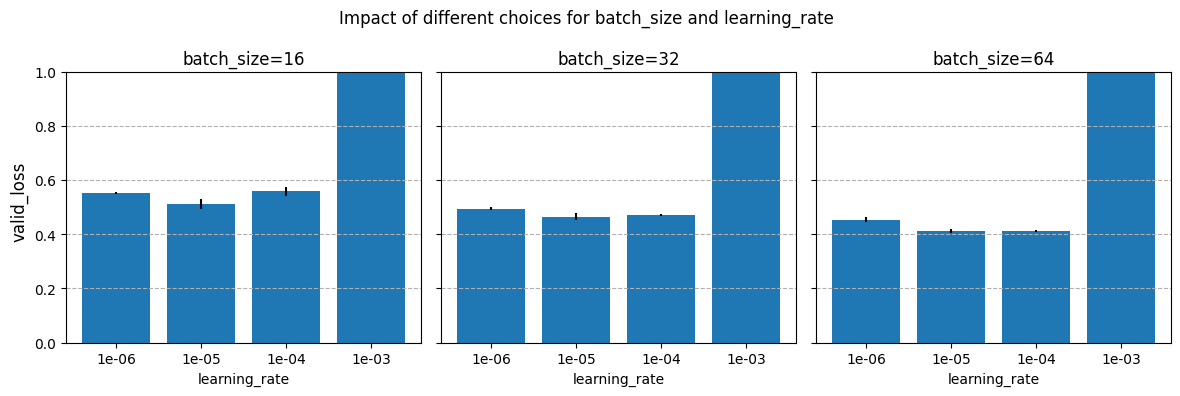

In [466]:
# Analyze impact of batch_size and learning_rate in session 1, or session 2 and 3
# Plot subplots per batch_size

# Uncomment one of the following lines
expnames = ['bart_base_session1']
# expnames = ['bart_base_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

batch_sizes = df['config/batch_size'].unique()
fig, ax = plt.subplots(ncols=len(batch_sizes), figsize=(12, 4), sharey=True)

for i, batch_size in enumerate(batch_sizes):
    selection = (df["config/batch_size"] == batch_size) # & (df["config/learning_rate"] != 1e-3)
    result_df = df[selection].groupby(['config/learning_rate']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    x_values = [f"{x:.0e}" for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)
    ax[i].set_title(f"batch_size={int(batch_size):d}")
    ax[i].set_xlabel("learning_rate")
    if i==0:
        ax[i].set_ylim(0,1)
    ax[i].grid(which='major', axis='y', linestyle='--')

fig.suptitle("Impact of different choices for batch_size and learning_rate")
fig.supylabel("valid_loss")
fig.tight_layout()

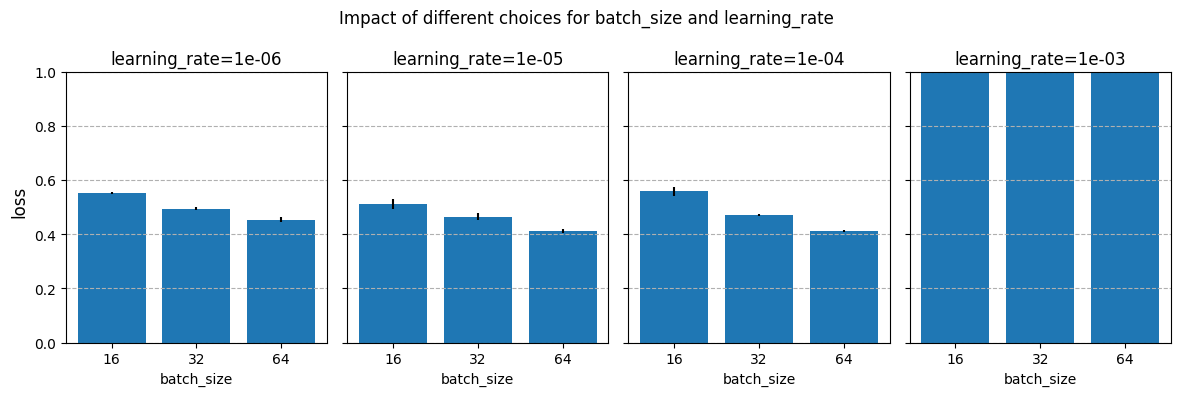

In [467]:
# Analyze impact of batch_size and learning_rate in session 1, or session 2 and 3
# Plot subplots per learning_rate

# Uncomment one of the following lines
expnames = ['bart_base_session1']
# expnames = ['bart_base_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

learning_rates = df['config/learning_rate'].unique()
fig, ax = plt.subplots(ncols=len(learning_rates), figsize=(12, 4), sharey=True)

for i, learning_rate in enumerate(learning_rates):
    selection = (df["config/learning_rate"] == learning_rate)
    result_df = df[selection].groupby(['config/batch_size']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    x_values = [f"{int(x):d}" for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)
    ax[i].set_title(f"learning_rate={learning_rate:.0e}")
    ax[i].set_xlabel("batch_size")
    if i==0:
        ax[i].set_ylim(0,1)
    ax[i].grid(which='major', axis='y', linestyle='--')
    
fig.suptitle("Impact of different choices for batch_size and learning_rate")
fig.supylabel("loss")
fig.tight_layout()

### Analyse impact of speaker_prefixes, nofact_token, add_tokens

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_96520/1038586990.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_96520/1038586990.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]


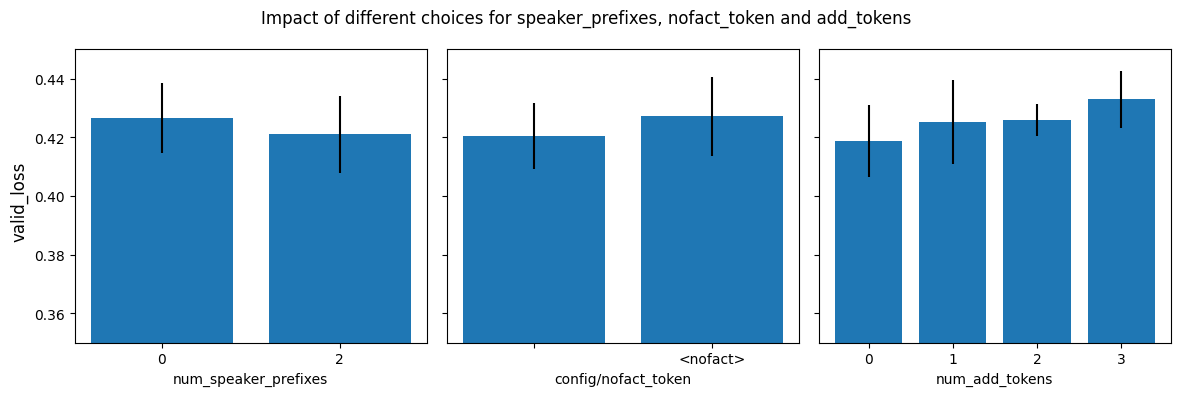

In [470]:

# Uncomment one of the following lines
expnames = ['bart_tokens_session1']
expnames = ['bart_tokens_sessions23']

exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

# Adjust labels for better plots
df['num_speaker_prefixes'] = [0 if x is None else len(x) for x in df['config/speaker_prefixes']]
df['num_add_tokens'] = [len(x) for x in df['config/add_tokens']]

grouplist = ['num_speaker_prefixes', 'config/nofact_token', 'num_add_tokens']
fig, ax = plt.subplots(ncols=len(grouplist), figsize=(12,4), sharey=True)

for i, grp in enumerate(grouplist):

    result_df = df[[grp] + ['valid_loss']].groupby(grp).agg(['mean', 'std'])

    x_values = [str(x) for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df[('valid_loss', 'mean')].values, yerr=result_df[('valid_loss', 'std')])

    ax[i].set_xlabel(grp)
    if i == 0:
        ax[i].set_ylim(0.35, 0.45)

fig.suptitle("Impact of different choices for speaker_prefixes, nofact_token and add_tokens")
fig.supylabel("valid_loss")
fig.tight_layout()

### Analyse impact of len_context

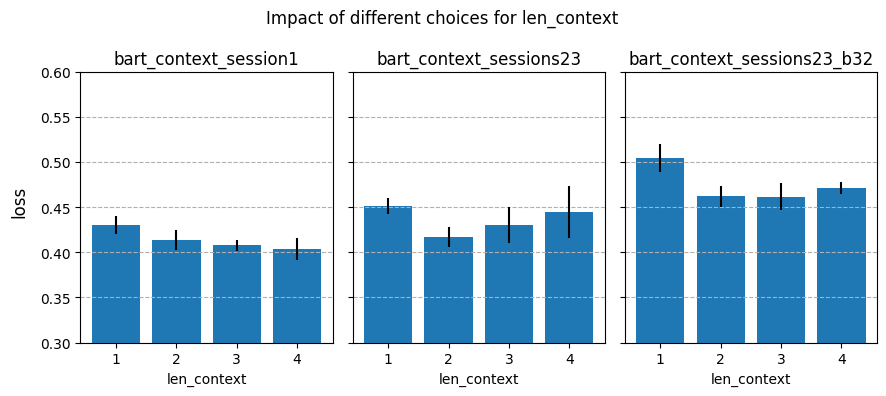

In [471]:
###
### Analyse impact of len_context
###

expnames = ['bart_context_session1', 'bart_context_sessions23', 'bart_context_sessions23_b32']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(ncols=len(expnames), figsize=(9, 4), sharey=True)

for i, expname in enumerate(expnames):

    selection = (df['experiment_name'] == expname)
    result_df = df[selection].groupby(['config/len_context']).agg({"valid_loss": ['mean', 'std']})['valid_loss']

    x_values = [f"{int(x):d}" for x in result_df.index]
    ax[i].bar(x=x_values, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("len_context")
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(expname)
    if i == 0:
        ax[i].set_ylim(0.3, 0.6)
    
fig.suptitle("Impact of different choices for len_context")
fig.supylabel("loss")
fig.tight_layout()

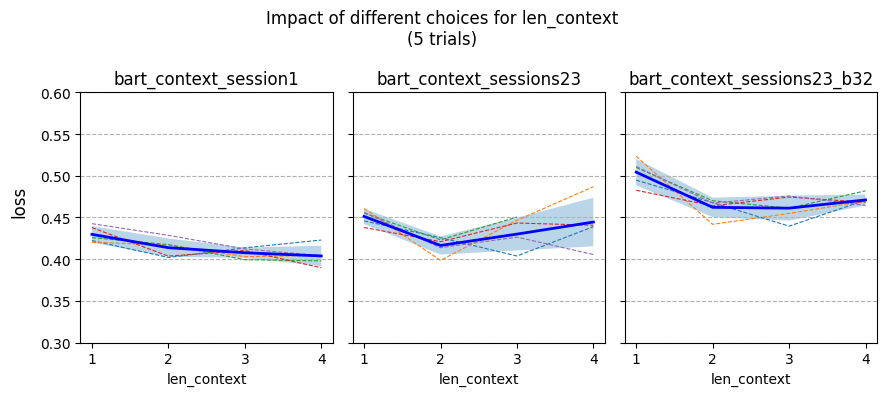

In [472]:
expnames = ['bart_context_session1', 'bart_context_sessions23', 'bart_context_sessions23_b32']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(ncols=len(expnames), figsize=(9, 4), sharey=True)

x_values = [f"{int(x):d}" for x in df['config/len_context'].unique()]
seeds = df['config/seed'].unique()

for i, expname in enumerate(expnames):
    for seed in seeds:
        selection = (df['config/seed'] == seed) & (df['experiment_name'] == expname)
        values = df[selection]['valid_loss'].values
        ax[i].plot(x_values[:len(values)], values, label=seed, linestyle='--', linewidth=0.8)

    selection = (df['experiment_name'] == expname)
    result_df = df[selection].groupby(['config/len_context']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    ax[i].plot(x_values, result_df['mean'].values, linewidth=2, c='b')
    ax[i].fill_between(x_values, result_df['mean'].values - result_df['std'].values, result_df['mean'].values + result_df['std'].values, alpha=0.3)
    ax[i].set_xlabel("len_context")
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(expname)
    if i == 0:
        ax[i].set_ylim(0.3, 0.6)
    
fig.suptitle("Impact of different choices for len_context\n(5 trials)")
fig.supylabel("loss")
fig.tight_layout()

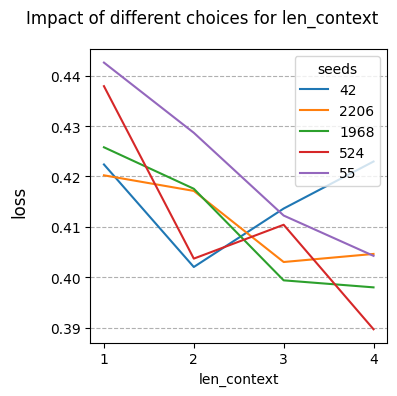

In [489]:
expnames = ['bart_context_session1']
exp_selection = (allresults_df['experiment_name'].isin(expnames))
df = allresults_df[exp_selection]

fig, ax = plt.subplots(figsize=(4, 4))

seeds = df['config/seed'].unique()
x_values = [f"{int(x):d}" for x in df['config/len_context'].unique()]

for seed in seeds:
    selection = (df['config/seed'] == seed)
    values = df[selection]['valid_loss'].values
    ax.plot(x_values[:len(values)], values, label=seed)
ax.legend(title='seeds', loc='upper right')
ax.set_xlabel("len_context")
ax.grid(which='major', axis='y', linestyle='--')
    
fig.suptitle("Impact of different choices for len_context")
fig.supylabel("loss")
fig.tight_layout()

### Analyse impact of bart_base

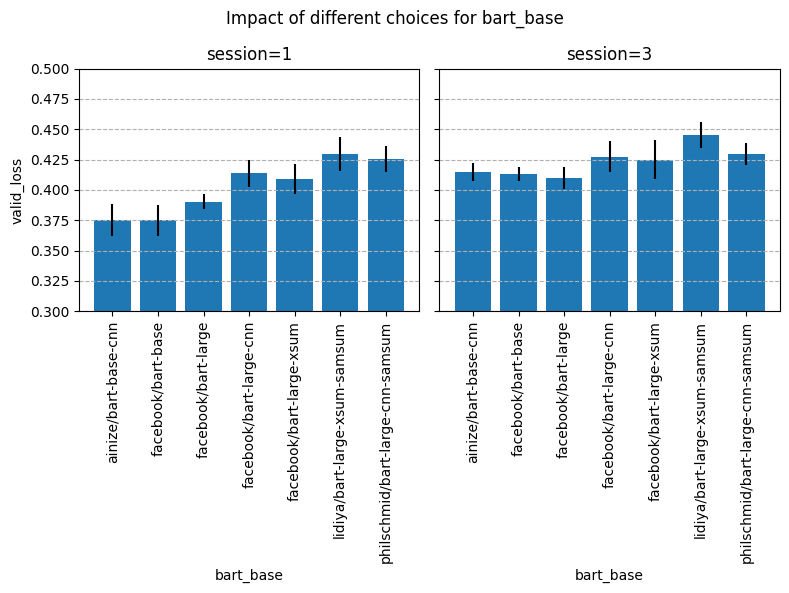

In [474]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].groupby(['config/bart_base']).agg({"valid_loss": ['mean', 'std']})['valid_loss']
    
    ax[i].bar(x=result_df.index, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("bart_base")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

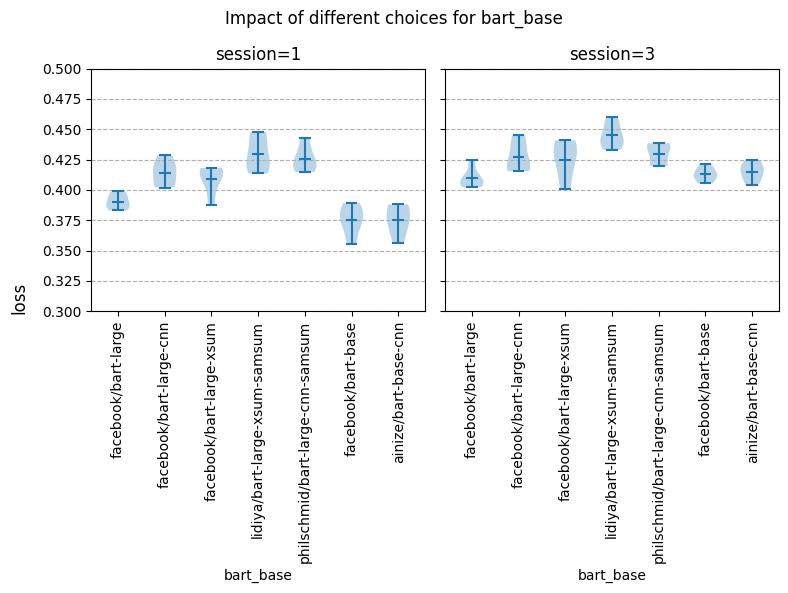

In [476]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]
basemodels = df["config/bart_base"].unique()

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

x_values = basemodels

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in basemodels
    ]

    ax[i].violinplot(data, showmeans=True)
    
    ax[i].set_xticks(range(1, len(basemodels) + 1), basemodels)
    ax[i].set_xlabel("bart_base")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.supylabel("loss")
fig.tight_layout()

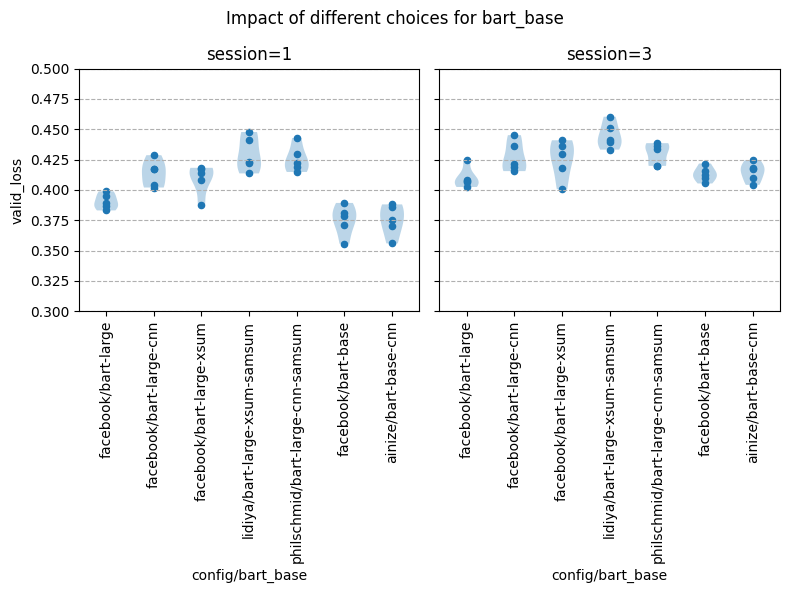

In [477]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]
basemodels = df["config/bart_base"].unique()

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

x_values = basemodels

for i, s in enumerate(session_list):

    # plot scatterchart with all datapoints
    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    scatter_ax = df[selection].plot.scatter('config/bart_base', 'valid_loss', ax=ax[i])

    # plot corresponding violinplots
    x_ticklabels = [label.get_text() for label in scatter_ax.get_xticklabels()]
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in x_ticklabels
    ]
    ax[i].violinplot(data, positions=range(len(x_ticklabels)), showmeans=False, showextrema=False)

    # add titles, atc
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylim(0.3, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

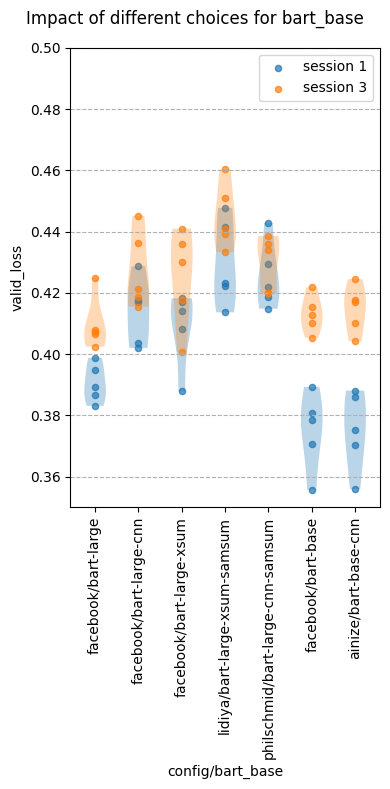

In [480]:

exp_selection = (allresults_df['experiment_name'] == 'bart_model_sessions13')
df = allresults_df[exp_selection]

session_list = [1, 3]

fig, ax = plt.subplots(figsize=(4, 8))
col = ['tab:blue', 'tab:orange']

for i, s in enumerate(session_list):

    # plot scatter chart with all datapoints
    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    scatter_ax = df[selection].plot.scatter('config/bart_base', 'valid_loss', c=col[i], alpha=0.7, label=f"session {s}", ax=ax)

    # plot corresponding violinplots
    x_ticklabels = [label.get_text() for label in scatter_ax.get_xticklabels()]
    data = [
        df[selection & (df['config/bart_base'] == basemodel)]["valid_loss"].values
        for basemodel in x_ticklabels
    ]
    ax.violinplot(data, positions=range(len(x_ticklabels)), showmeans=False, showextrema=False)

    # add titles, etc
    ax.tick_params(axis='x', labelrotation = 90)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_ylim(0.35, 0.5)
    
fig.suptitle("Impact of different choices for bart_base")
fig.tight_layout()

### Analyse impact of clf_loss and lm_loss_factor

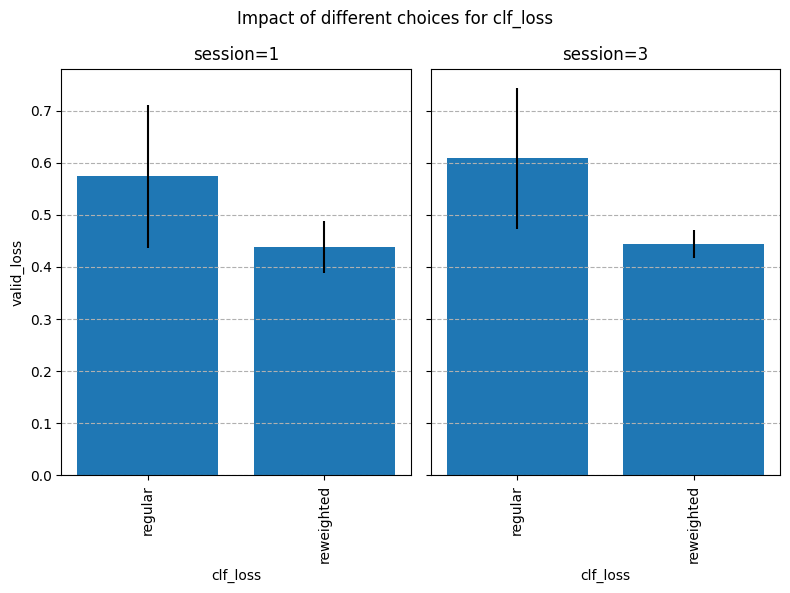

In [483]:
###
### Analyse impact of clf_loss and lm_loss_factor
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].fillna(value="regular").groupby(by=['config/clf_loss'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']

    ax[i].bar(x=result_df.index, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("clf_loss")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for clf_loss")
fig.tight_layout()

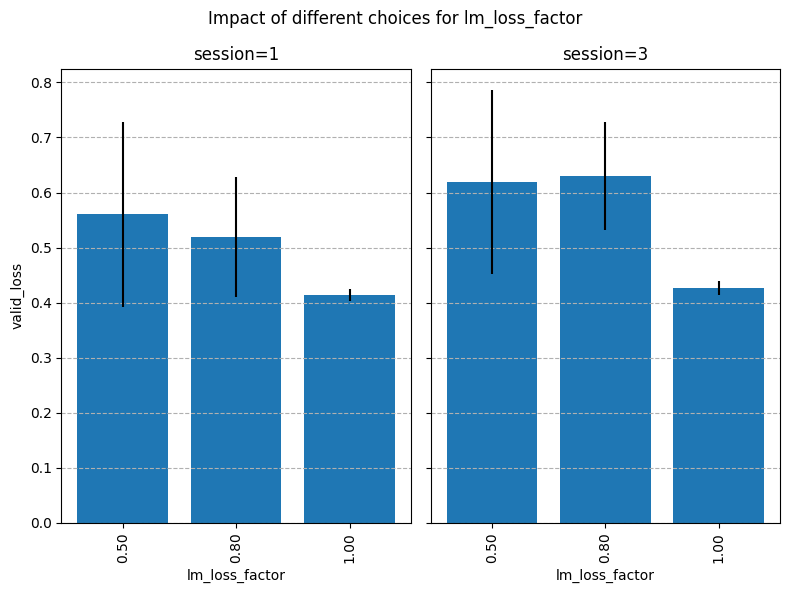

In [485]:
###
### Analyse impact of clf_loss and lm_loss_factor
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') #| (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)

session_list = [1, 3]
fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 6), sharey=True)

for i, s in enumerate(session_list):

    selection = (df['config/sessions'] == pd.Series([[s]] * len(df)))
    result_df = df[selection].fillna(value="None").groupby(by=['config/lm_loss_factor'], dropna=False).agg({"valid_loss": ['mean', 'std']})['valid_loss']

    x_ticklabels = [f"{x:.2f}" for x in result_df.index]
    bar_ax = ax[i].bar(x=x_ticklabels, height=result_df['mean'].values, yerr=result_df['std'].values)

    ax[i].set_xlabel("lm_loss_factor")
    ax[i].tick_params(axis='x', labelrotation = 90)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    if i == 0:
        ax[i].set_ylabel("valid_loss")
    
fig.suptitle("Impact of different choices for lm_loss_factor")
fig.tight_layout()

Mean of valid_loss, when lm_loss_factor > 0.95: 0.42
Mean of valid_loss, when lm_loss_factor < 0.95 and clf_loss == reweighted: 0.44


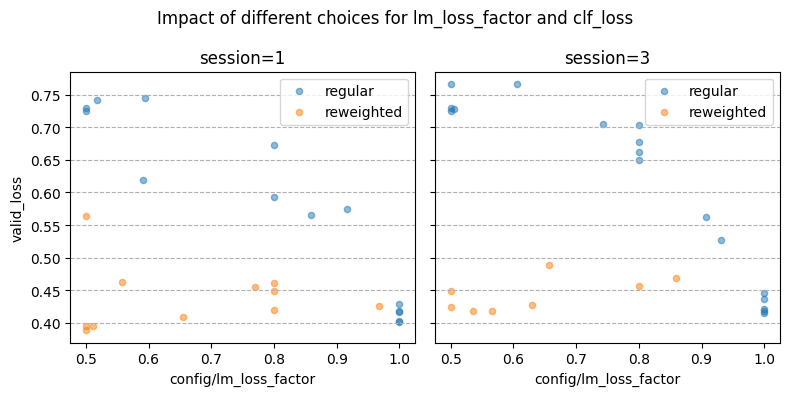

In [490]:

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
df['config/clf_loss'] = df['config/clf_loss'].fillna(value='regular')

variants = ['regular', 'reweighted']
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 4), sharey=True)
col = {'regular': 'tab:blue', 'reweighted': 'tab:orange'}

for i, s in enumerate(session_list):

    for variant in variants:
        selection = (df['config/sessions'] == pd.Series([[s]] * len(df))) & (df['config/clf_loss'] == variant)
        scatter_ax = df[selection].plot.scatter('config/lm_loss_factor', 'valid_loss', c=col[variant], label=variant, alpha=0.5, ax=ax[i])

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"session={s}")
    
fig.suptitle("Impact of different choices for lm_loss_factor and clf_loss")
fig.tight_layout()

print(f"Mean of valid_loss, when lm_loss_factor > 0.95: {df[(df['config/lm_loss_factor'] > 0.95)]['valid_loss'].mean():.2f}")
print(f"Mean of valid_loss, when lm_loss_factor < 0.95 and clf_loss == reweighted: {df[(df['config/lm_loss_factor'] < 0.95) & (df['config/clf_loss'] == 'reweighted')]['valid_loss'].mean():.2f}")

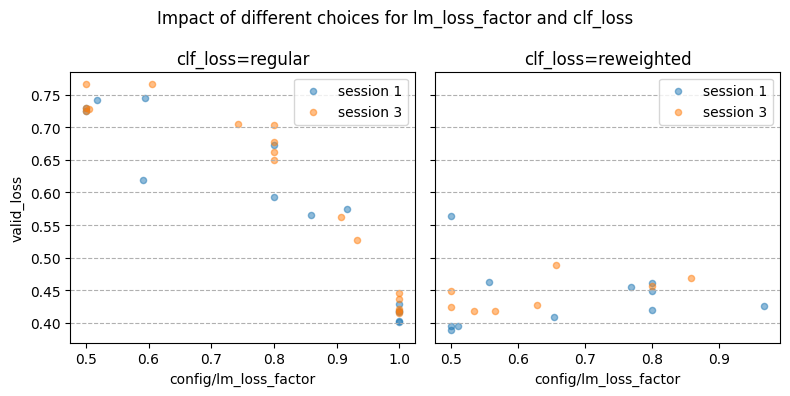

In [487]:
###
### Analyse impact of len_context
###

exp_selection = (allresults_df['experiment_name'] == 'bart_loss_sessions13') | (allresults_df['experiment_name'] == 'bart_loss_sessions13_v2')
df = allresults_df[exp_selection].reset_index(drop=True)
df['config/clf_loss'] = df['config/clf_loss'].fillna(value='regular')

variants = ['regular', 'reweighted']
session_list = [1, 3]

fig, ax = plt.subplots(ncols=len(session_list), figsize=(8, 4), sharey=True)
col = {1: 'tab:blue', 3: 'tab:orange'}

for i, variant in enumerate(variants):

    for s in session_list:
        selection = (df['config/clf_loss'] == pd.Series([variant] * len(df))) & (df['config/sessions'] == pd.Series([[s]] * len(df)))
        scatter_ax = df[selection].plot.scatter('config/lm_loss_factor', 'valid_loss', c=col[s], alpha=0.5, label=f"session {s}", ax=ax[i])
    
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"clf_loss={variant}")
    
fig.suptitle("Impact of different choices for lm_loss_factor and clf_loss")
fig.tight_layout()

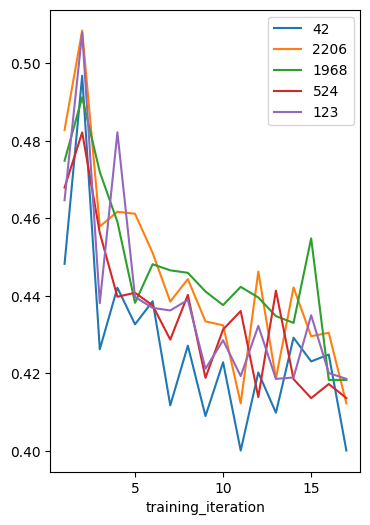

In [18]:
batch_size = 64
learning_rate = 1e-5

fig, ax = plt.subplots(figsize=(4,6))

for result in result_grid:
    if result.config['batch_size'] == batch_size and result.config['learning_rate'] == learning_rate:
        result.metrics_dataframe.plot("training_iteration", "valid_loss", ax=ax, label=result.config['seed'])

<Axes: xlabel='training_iteration'>

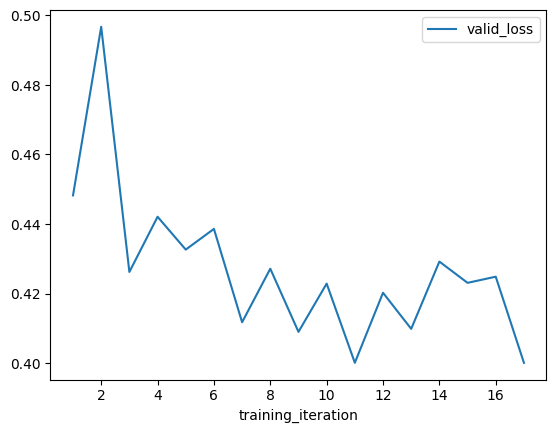

In [10]:
best_result = result_grid.get_best_result()
best_result.metrics_dataframe.plot("training_iteration", "valid_loss")

In [16]:
df['valid_acc'].max()

0.75

In [17]:
df.groupby(by=grouplist, dropna=False)['valid_acc', 'time_total_s', 'training_iteration'].agg({'valid_acc': ['max', 'mean', 'std', 'count'], 'time_total_s': ['mean'], 'training_iteration': ['mean']})

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_99543/3988520531.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(by=grouplist, dropna=False)['valid_acc', 'time_total_s', 'training_iteration'].agg({'valid_acc': ['max', 'mean', 'std', 'count'], 'time_total_s': ['mean'], 'training_iteration': ['mean']})


valid_acc                 time_total_s  \
                                        max  mean std count         mean   
config/lm_loss_factor config/seed                                          
0.264618              42               0.75  0.75 NaN     1    54.168999   
0.388080              42               0.75  0.75 NaN     1    55.372039   

                                  training_iteration  
                                                mean  
config/lm_loss_factor config/seed                     
0.264618              42                         4.0  
0.388080              42                         4.0

In [235]:
## OLD RAY_RESULTS FROM TUNING PREFIXBERT

ray_results_dir = "/Users/FrankVerhoef/Programming/PEX/checkpoints/ray_results/"
experiments = [
    {
        'exp_file': "train_with_args_2023-03-29_23-24-42", 
        'comment': "Tune PrefixBert with speaker prefixes <self>, <other>",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/prefix_aggr', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_10-12-15", 
        'comment': "Tune PrefixBert without speaker prefixes",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-21-13", 
        'comment': "Tune Bart, without speaker prefixes",
        'grouplist': ['config/learning_rate', 'config/batch_size']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-55-16", 
        'comment': "Tune PrefixBart"
    },
]

exp=experiments[2]
exp_name = exp['exp_file']
grouplist = exp['grouplist']
restored_tuner = tune.Tuner.restore(ray_results_dir + exp_name)
result_grid = restored_tuner.get_results()
len(result_grid)

In [18]:
df_grouped = df.groupby(by=grouplist, dropna=False)

In [19]:
df_mean = df_grouped['valid_acc'].agg(['mean']).unstack()['mean']
df_mean

config/seed,42
config/lm_loss_factor,
0.264618,0.75
0.388080,0.75


In [20]:
cols = df_mean.columns
df_mean.columns = [f"{c[0]}, {c[1]}" for c in cols]
df_mean.columns

TypeError: 'int' object is not subscriptable

Text(0.5, 1.0, 'Tune Bart, without speaker prefixes')

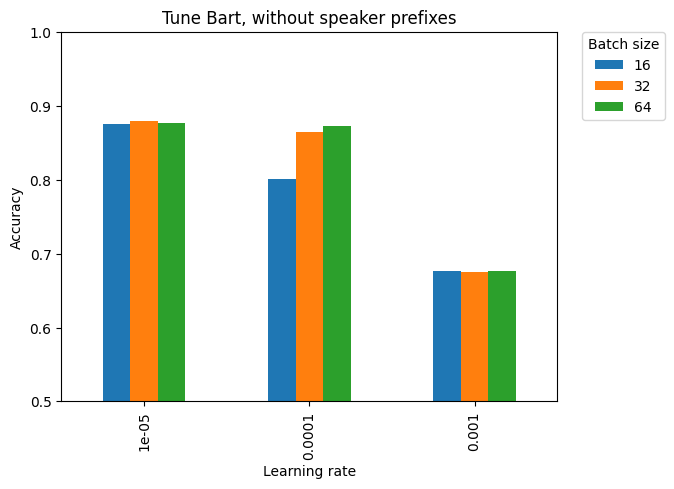

In [249]:
# df_mean.plot.bar(figsize=(10,3))
df_mean.plot.bar()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Batch size")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
# plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.xlabel("Learning rate")
plt.title(exp['comment'])# + "\nwith various model configurations and training parameters")

In [250]:
# df_time = df_grouped['time_total_s'].agg(['mean']).unstack().unstack()
df_time = df_grouped['time_total_s'].agg(['mean']).unstack()['mean']
df_time

config/batch_size,16,32,64
config/learning_rate,,,
0.00001,678.743218,720.292901,630.831672
0.00010,549.888993,649.055010,600.018667
0.00100,268.237531,413.387231,429.284796


Text(0.5, 1.0, 'Tune Bart, without speaker prefixes\nwith various model configurations and training parameters')

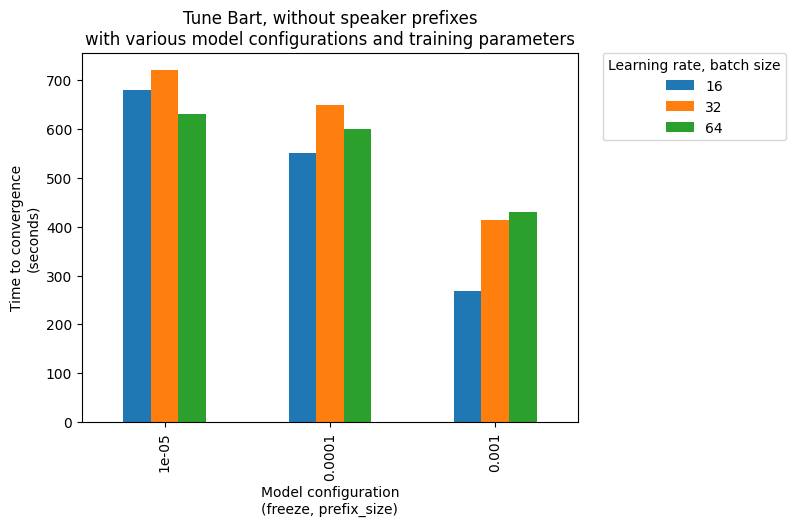

In [252]:
# df_time['mean'].plot.bar(figsize=(10,3))
df_time.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.ylabel("Time to convergence\n(seconds)")
plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.title(exp['comment'] + "\nwith various model configurations and training parameters")

In [183]:
# Get the result with the maximum test set `mean_accuracy`
best_result = result_grid.get_best_result()
best_result.config

{'seed': 42,
 'prefix_aggr': 'concat',
 'learning_rate': 0.0001,
 'batch_size': 32,
 'prefix_size': 0,
 'freeze': 8}

<Axes: xlabel='training_iteration'>

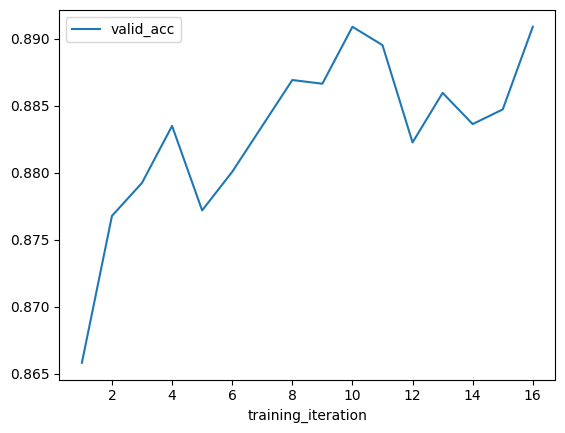

In [184]:
best_result.metrics_dataframe.plot("training_iteration", "valid_acc")

In [185]:
df.groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_size'])['valid_acc', 'time_total_s'].agg(['mean', 'std'])

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_5608/397826947.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_size'])['valid_acc', 'time_total_s'].agg(['mean', 'std'])


valid_acc  \
                                                                             mean   
config/batch_size config/learning_rate config/freeze config/prefix_size             
16                0.00001              8.0           0                   0.881273   
                                       12.0          0                   0.726099   
                                                     5                   0.713721   
                  0.00010              8.0           0                   0.885096   
                                       12.0          0                   0.855495   
                                                     5                   0.854533   
                  0.00100              8.0           0                   0.691703   
                                       12.0          0                   0.845948   
                                                     5                   0.847237   
32                0.00001              8.0           0                   0.884663   
                                       12.0          0                   0.699150   
                                                     5                   0.707861   
                  0.00010              8.0           0                   0.888706   
                                       12.0          0                   0.852419   
                                                     5                   0.860791   
                  0.00100              8.0           0                   0.675713   
                                       12.0          0                   0.854715   
                                                     5                   0.855096   
64                0.00001              8.0           0                   0.881340   
                                       12.0          0                   0.698063   
                                                     5                   0.699299   
                  0.00010              8.0           0                   0.889848   
                                       12.0          0                   0.851387   
                                                     5                   0.852151   
                  0.00100              8.0           0                   0.723517   
                                       12.0          0                   0.861340   
                                                     5                   0.859768   

                                                                                   \
                                                                              std   
config/batch_size config/learning_rate config/freeze config/prefix_size             
16                0.00001              8.0           0                   0.003859   
                                       12.0          0                   0.035966   
                                                     5                   0.051199   
                  0.00010              8.0           0                   0.000789   
                                       12.0          0                   0.003709   
                                                     5                   0.005765   
                  0.00100              8.0           0                   0.034892   
                                       12.0          0                   0.006508   
                                                     5                   0.004273   
32                0.00001              8.0           0                   0.000485   
                                       12.0          0                   0.026361   
                                                     5                   0.048871   
                  0.00010              8.0           0                   0.002342   
                                       12.0          0                   0.006228   
                                                     5                   0.0

In [187]:
df[df['config/prefix_size'] == 5].groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_aggr'])['valid_acc'].max()

config/batch_size  config/learning_rate  config/freeze  config/prefix_aggr
16                 0.00001               12.0           avg                   0.676374
                                                        concat                0.799313
                                                        max                   0.700137
                   0.00010               12.0           avg                   0.851648
                                                        concat                0.862775
                                                        max                   0.857967
                   0.00100               12.0           avg                   0.853571
                                                        concat                0.846566
                                                        max                   0.849451
32                 0.00001               12.0           avg                   0.675713
                                                       